In [8]:
from shapely.geometry import Polygon
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
import fitsio
import matplotlib.pyplot as plt 
import shapely
from gPhoton.coords.gnomonic import gnomfwd_simple, gnomrev_simple
from gPhoton.constants import DETSIZE, PIXEL_SIZE
import pyarrow.parquet as pq

In [47]:
eclipse = 580


In [51]:
### ZACKS CODE FOR SHAPELY MASKS 

# hardcoded cdelt and cenpix parameters from load_aspect_solution
CDELT  = 1.0 / 36000.0
CENPIX = 0.0

# detector aperture radius in xi/eta units
APERTURE_RADIUS = (DETSIZE / CDELT) / 2

# Shapely has no concept of arcs; curves must be approximated using a
# sequence of lines.  The polygon generated by Point(x,y).buffer(r) is
# guaranteed to be inscribed within a true circle of radius r.  The
# approximation can be made more precise by increasing this parameter,
# which is the number of segments to use for each quarter-circle.
#
# At QUAD_SEGS = 72, the approximation of a circle with radius
# APERTURE_RADIUS has area 1262 cdelt^2 units smaller than a true
# circle with that radius; this is a relative error of 0.008%,
# which we should be able to live with.
QUAD_SEGS = 72

def areas_for_leg(ra0, dec0, aspect):
    # convert the aspect solution to plate coordinates
    ra = aspect["ra"].to_numpy()
    dec = aspect["dec"].to_numpy()
    roll = aspect["roll"].to_numpy()
    ra0 = ra0.to_numpy()
    dec0 = dec0.to_numpy()
    print(type(ra0))
	# discard flagged points, points immediately before or after flagged
    # points, and points whose time step isn't 1 second
    times = aspect["time"].to_numpy()
    timedelta_is_1 = np.insert(
		np.isclose(times[1:] - times[:-1], 1.0), 
		0, True
    )
    flagged = aspect["flags"].to_numpy() % 2 != 0
    prev_flagged = np.concatenate([[False], flagged[:-1]]) & ~flagged
    next_flagged = np.concatenate([flagged[1:], [False]]) & ~flagged

    ok = ~flagged & ~prev_flagged & ~next_flagged & timedelta_is_1
    xi, eta = gnomfwd_simple(
        ra[ok],
        dec[ok],
        ra0,
        dec0,
        -roll[ok],
        CDELT,
        CENPIX
    )
    ap_points = shapely.points(xi, eta)
	
	# for each point, find the detector aperture with that point at its center
    ap_disks = shapely.buffer(
        ap_points,
        APERTURE_RADIUS,
        quad_segs=QUAD_SEGS,
	)

    # The union of all the ap_disks gives the area (on an imaginary
    # photographic plate of unbounded extent) that was exposed to
    # incoming light; the intersection of all the ap_disks gives the
    # area that was exposed for the full exposure time of the leg;
    # and finally, the difference (union minus intersection) is the
    # region of the imaginary plate that didn't get fully exposed,
    # therefore source finding is likely to be unreliable within.
    full = shapely.intersection_all(ap_disks)
    edge = shapely.difference(shapely.union_all(ap_disks), full)
	
    return full, edge

### clipping for image 
def centile_clip(image, centiles=(1, 99)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data



In [52]:
# get aspect / boresight data 
aspect = pq.read_table(
    "/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet",
    filters=[("eclipse", "==", eclipse)]
)
boresight = pq.read_table(
    "/home/bekah/gPhoton2/gPhoton/aspect/boresight.parquet",
    filters=[("eclipse", "==", eclipse)]
)

ra0 = boresight['ra0']
dec0 = boresight['dec0']
roll = boresight['roll0']

In [53]:
# get shapely shapes
full, edge = areas_for_leg(ra0, dec0, aspect)

<class 'numpy.ndarray'>


In [55]:
# get wcs info 
with fits.open(f"/home/bekah/eclipse/e{str(eclipse).zfill(5)}/e{str(eclipse).zfill(5)}-nd-ffull-b00-image-r.fits") as hdul:
    header = hdul[1].header  
    wcs = WCS(header)

In [56]:
# use exterior coordinates of the mask for EDGE MASK 
x, y = edge.exterior.coords.xy
ra_poly, dec_poly = gnomrev_simple(
    np.asarray(x),
    np.asarray(y),
    ra0.to_numpy(),     
    dec0.to_numpy(),   
    -roll.to_numpy(),   
    1 / 36000.0,  
    0.0,
    0.0
)  
image_coords = wcs.wcs_world2pix(np.column_stack((ra_poly, dec_poly)), 1)
image_edge = Polygon(image_coords)


In [57]:
# use exterior coordinates of the mask for FULL MASK 
x, y = full.exterior.coords.xy
ra_poly, dec_poly = gnomrev_simple(
    np.asarray(x),
    np.asarray(y),
    ra0.to_numpy(),     
    dec0.to_numpy(),   
    -roll.to_numpy(),   
    1 / 36000.0,  
    0.0,
    0.0
)  
image_coords = wcs.wcs_world2pix(np.column_stack((ra_poly, dec_poly)), 1)
image_full = Polygon(image_coords)


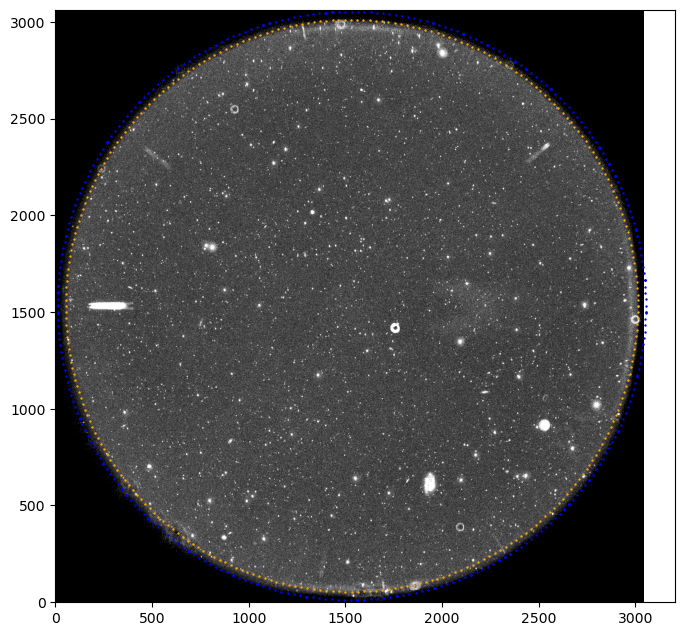

In [58]:
# make plots of masks on top of fits cnt image 
hdul = fits.open(f"/home/bekah/eclipse/e{str(eclipse).zfill(5)}/e{str(eclipse).zfill(5)}-nd-ffull-b00-image-r.fits")
cnt = hdul[1].data

plt.figure(figsize=(8, 8))
plt.imshow(centile_clip(cnt),cmap='grey',origin='lower')
plt.scatter(image_edge.exterior.xy[0],image_edge.exterior.xy[1],color='blue',s=.5)
plt.scatter(image_full.exterior.xy[0],image_full.exterior.xy[1],color='orange',s=.5)